<a href="https://colab.research.google.com/github/patrickzoechbauer/beyondmcmc/blob/main/MultivariateGaussSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 0: Install numpyro as well as RAABBVI 

In [ ]:
!pip install numpyro
!pip install pystan==2.19.1.1
!pip install git+https://github.com/Manushi22/viabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 291 kB 5.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 1.3 MB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Manushi22/viabel to /tmp/pip-req-build-lbx2jly_
  Running command git clone -q https://github.com/Manushi22/viabel /tmp/pip-req-build-lbx2jly_
     |████████████████████████████████| 41 kB 127 kB/s 
  Created wheel for viabel: filename=viabel-0.4.2-py3-none-any.whl size=40398 sha256=f3a9d0aaea0ae3ca11d462a033db6b1c7dc13a38b9f64348e79a69880c1aae76
  Stored in directory: /tmp/pip-ephem-wheel-cache-zdk5hwtt

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats
import random
import time
import pickle

import numpyro
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide
import numpyro.distributions as dist
#assert numpyro.__version__.startswith("0.9.2")

import jax.numpy as jnp
from jax.random import PRNGKey

from scipy.stats import multivariate_normal
from scipy.stats import genpareto
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp

import viabel
from viabel.optimization import FASO, RMSProp, RAABBVI
from viabel.objectives import ExclusiveKL
from viabel.approximations import MFGaussian, MultivariateT, ApproximationFamily
from viabel.models import Model
from viabel import bbvi, MFStudentT
from viabel.diagnostics import all_diagnostics 

import arviz

from tqdm.notebook import tqdm, trange
import os, sys

# Section 1: Define functions to train MCMC, ADVI and RAABBVI

In [ ]:
from paragami import (
    FlattenFunctionInput, NumericArrayPattern, NumericVectorPattern, PatternDict,
    PSDSymmetricMatrixPattern)

def _get_mu_sigma_pattern(dim):
    ms_pattern = PatternDict(free_default=True)
    ms_pattern['mu'] = NumericVectorPattern(length=dim)
    ms_pattern['Sigma'] = PSDSymmetricMatrixPattern(size=dim)
    return ms_pattern

In [ ]:
import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
from autograd.scipy.linalg import sqrtm

class MultivariateGaussian(ApproximationFamily):
    """A full-rank multivariate Gaussian approximation family."""

    def __init__(self, dim, seed=1):
        self._rs = npr.RandomState(seed)
        self._pattern = _get_mu_sigma_pattern(dim)
        self._log_density = FlattenFunctionInput(
            lambda param_dict, x: multivariate_normal.logpdf(
                x, param_dict['mu'], param_dict['Sigma']),
            patterns=self._pattern, free=True, argnums=0)
        super().__init__(dim, self._pattern.flat_length(True), True, True)

    def init_param(self):
        init_param_dict = dict(mu=np.zeros(self.dim),
                               Sigma=10 * np.eye(self.dim))
        return self._pattern.flatten(init_param_dict)

    def sample(self, var_param, n_samples, seed=None):
        my_rs = self._rs if seed is None else npr.RandomState(seed)
        param_dict = self._pattern.fold(var_param)
        z = my_rs.randn(n_samples, self.dim)
        sqrtSigma = sqrtm(param_dict['Sigma'])
        return param_dict['mu'] + np.dot(z, sqrtSigma)

    def entropy(self, var_param):
        # ignore terms that depend only on df
        param_dict = self._pattern.fold(var_param)
        #return .5 * np.log(np.linalg.det(param_dict['Sigma']))
        _, logdet = np.linalg.slogdet(2 * np.pi * np.e * param_dict['Sigma'])
        return 0.5 * logdet

    def log_density(self, var_param, x):
        return self._log_density(var_param, x)

    def mean_and_cov(self, var_param):
        param_dict = self._pattern.fold(var_param)
        return param_dict['mu'], param_dict['Sigma']

    def _pth_moment(self, var_param, p):
        param_dict = self._pattern.fold(var_param)
        sq_scales = np.linalg.eigvalsh(param_dict['Sigma'])
        return np.sum(sq_scales)

    def supports_pth_moment(self, p):
        return p in [2]

    def _kl(self, var_param0, var_param1):
        # get params
        param_dict0 = self._pattern.fold(var_param0)
        param_dict1 = self._pattern.fold(var_param1)

        m0 = param_dict0['mu']
        m1 = param_dict1['mu']

        S0 = param_dict0['Sigma']
        S1 = param_dict1['Sigma']
        
        # store inv diag covariance of S1 and diff between means
        N = m0.shape[0]
        iS1 = np.linalg.inv(S1)
        diff = m1 - m0

        # kl is made of three terms
        tr_term   = np.trace(iS1 @ S0)
        det_term  = np.log(np.linalg.det(S1)/np.linalg.det(S0)) #np.sum(np.log(S1)) - np.sum(np.log(S0))
        quad_term = diff.T @ np.linalg.inv(S1) @ diff #np.sum( (diff*diff) * iS1, axis=1)
        #print(tr_term,det_term,quad_term)
        return .5 * (tr_term + det_term + quad_term - N) 


    @property
    def df(self):
        """Degrees of freedom."""
        return self._df

In [ ]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
  
set_seed(1)

In [ ]:
'''
def sample_data(N=8):
  mu = 2
  tau = 1
  logsigma = np.random.normal(loc = 0, scale = 1, size = (N,))
  sigma = np.exp(logsigma)

  theta = np.random.normal(loc = mu, scale = tau, size = (N,))
  y = np.random.normal(loc = theta, scale = sigma, size = (N,))

  return y, sigma, theta, mu, tau
'''

'\ndef sample_data(N=8):\n  mu = 2\n  tau = 1\n  logsigma = np.random.normal(loc = 0, scale = 1, size = (N,))\n  sigma = np.exp(logsigma)\n\n  theta = np.random.normal(loc = mu, scale = tau, size = (N,))\n  y = np.random.normal(loc = theta, scale = sigma, size = (N,))\n\n  return y, sigma, theta, mu, tau\n'

In [ ]:
def sample_data(N = 10):
  a = 1.5
  b = 2
  sigma_a = 3  # std dev in intercepts
  sigma_b = 2.5  # std dev in slopes
  rho = 0.7  # correlation between intercepts and slopes
  sigmas = np.array([sigma_a, sigma_b])  # standard deviations
  Rho = np.array([[1, rho], [rho, 1]])  # correlation matrix
  # now matrix multiply to get covariance matrix
  Sigma = np.diag(sigmas) @ Rho @ np.diag(sigmas)

  Mu = np.array([a, b])

  y = np.random.multivariate_normal(mean = Mu, cov = Sigma, size = (N,))
  return y, Sigma

In [ ]:
y, Sigma = sample_data(N = 500)

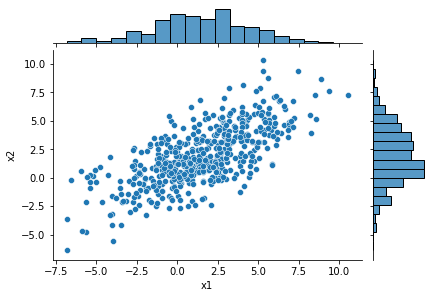

In [ ]:
data = pd.DataFrame(y, columns = ['x1', 'x2'])
# Joint plots shows bivariate scatterplots
# And univariate histograms
grid = sns.jointplot(x = 'x1', y = 'x2', data = data)
grid.fig.set_figwidth(6)
grid.fig.set_figheight(4)
plt.savefig('example1a.pdf')

In [ ]:
# Defines probabilistc model for numpyro
def model(X, Y=None):
  N, D = Y.shape
  Sigma = numpyro.deterministic('Sigma', X)
  mu = numpyro.sample('mu', dist.Normal(0.0, 1.0).expand([D]).to_event(1))

  #mu1 = numpyro.sample('mu1', dist.Normal(0.0, 1.0))
  #mu2 = numpyro.sample('mu2', dist.Normal(0.0, 1.0))

  with numpyro.plate('obs', N):
    numpyro.sample('y', dist.MultivariateNormal(mu, Sigma), obs = Y)

In [ ]:
# Defines probabilistc model for numpyro
def model_full_2d(X, Y=None):
  N, D = Y.shape

  sigma_a = numpyro.sample("sigma_a", dist.HalfCauchy(1))
  sigma_b = numpyro.sample("sigma_b", dist.HalfCauchy(1))
  rho = numpyro.sample('rho', dist.Normal(0,1))
 
  sigmas = jnp.array([sigma_a, sigma_b])  # standard deviations
  Rho = jnp.array([[1, rho], [rho, 1]])  # correlation matrix
  # now matrix multiply to get covariance matrix
  cov_mat = jnp.diag(sigmas) @ Rho @ jnp.diag(sigmas)

  mu_1 = numpyro.sample('mu1', dist.Normal(0.0, 1.0))
  mu_2 = numpyro.sample('mu2', dist.Normal(0.0, 1.0))

  mu = jnp.array([mu_1, mu_2])

  with numpyro.plate('obs', N):
    numpyro.sample('y', dist.MultivariateNormal(mu, cov_mat), obs = Y)

In [ ]:
# Function to run MCMC with NUTS sampler
def run_mcmc(model, num_warmup, num_samples, num_chains, X, Y, summary = False):
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
    )
    mcmc.run(PRNGKey(1), X, Y)
    if summary:
      mcmc.print_summary()
    return mcmc.get_samples()

In [ ]:
posterior_samples = run_mcmc(model_full_2d, 1000, 1000, 1, Sigma, y, True)

sample: 100%|██████████| 2000/2000 [00:06<00:00, 312.06it/s, 7 steps of size 4.73e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       mu1      1.43      0.14      1.42      1.22      1.66    620.92      1.00
       mu2      1.94      0.12      1.94      1.74      2.12    610.49      1.00
       rho      0.69      0.02      0.69      0.65      0.73    664.49      1.00
   sigma_a      2.98      0.09      2.98      2.82      3.12    621.94      1.00
   sigma_b      2.55      0.08      2.54      2.42      2.68    710.98      1.00

Number of divergences: 0


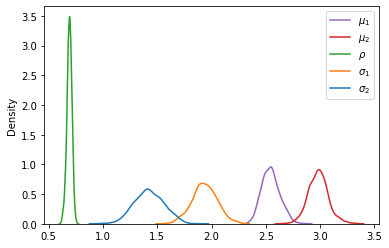

In [ ]:
df_posterior= pd.DataFrame.from_dict(posterior_samples)
fig = sns.kdeplot(data=df_posterior,
                  legend = False
                  )
plt.legend(loc='upper right', 
           labels=['$\mu_1$', '$\mu_2$', r'$\rho $', '$\sigma_1$', '$\sigma_2$'])
plt.savefig('example1b.pdf')

In [ ]:
# Functions to run VI using RAAABBVI
def log_density(theta):  
    import autograd.numpy as np
    import autograd.scipy.stats.norm as norm
    import autograd.scipy.stats.gamma as gamma
    import autograd.scipy.stats.multivariate_normal as multivariate_normal

    mu_q = theta

    #Priors: 
    mu_q = mu_q.mean(axis = 0).squeeze()
    mu_density = np.sum(norm.logpdf(mu_q, 0, 1))

    #likelihood 
    y_density = np.sum(multivariate_normal.logpdf(y, mu_q, Sigma))

    return y_density + mu_density 

def raabbvi(dimension, n_iters=10000, num_mc_samples=10, log_density=None, 
            learning_rate=0.1, RMS_kwargs={'diagnostics':True}, FASO_kwargs=dict()):
    """Fit a model using black-box variational inference.
    """
    model = Model(log_density)
    #approx = MFGaussian(dimension)
    #approx = MultivariateT(dimension, 3)
    approx = MultivariateGaussian(dimension)
    objective = ExclusiveKL(approx, model, num_mc_samples)
    init_var_param = approx.init_param()

    base_opt = RMSProp(learning_rate, **RMS_kwargs)
    #opt = FASO(base_opt, **FASO_kwargs)
    opt = RAABBVI(base_opt, **FASO_kwargs)

    opt_results = opt.optimize(n_iters, objective, init_var_param)
    opt_results['objective'] = objective
    return opt_results, approx

In [ ]:
# Function to calculate PSIS for numpyro VI approx 
def calcPSIS(vi_guide, vi_params):
  #Step 3: Get samples \theta_s for s = 1,...,S
  S = 10000
  samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (S,))
  theta = samples_vi['mu'].to_py()
  
  #Step 4: Calcualte the importance ratio

  #calc log(p(\theta_s, y))

  lp_target = log_density(theta)
  #lp_target += np.log(samples_vi['sigma'].to_py())
  ###log(sigma) is the jacobian term in the joint density using log(sigma) as the transformed parameters.

  # calc log(q(\theta_s))
  vi_mean = vi_params['auto_loc'].to_py()
  vi_sd = vi_params['auto_loc'].to_py()
  vi_cov = np.matmul(vi_params['auto_scale_tril'].T, 
                     vi_params['auto_scale_tril'])

  var = multivariate_normal(mean=vi_mean, 
                            cov=vi_cov,
                            allow_singular = True)
  
  lp_vi = var.logpdf(theta)

  # calc the ratio
  lp_ratio = lp_target-lp_vi

  # Step 5: 
  #select largest M of lp_ratio
  M = int(np.min([S/5, 3*np.sqrt(S)]))
  log_rs_largest = np.partition(lp_ratio,-M)[-M:]

  _, k = arviz.psislw(log_rs_largest, 0.8)

  return k

In [ ]:
def H2(log_weights, alpha=2.):
  log_weights = np.asarray(log_weights)
  log_rescale = np.max(log_weights)

  rescaled_weights = np.exp(log_weights - log_rescale)**alpha
  mean_rescaled_weight = np.mean(rescaled_weights)
  cubo = np.log(mean_rescaled_weight) / alpha + log_rescale
  log_norm_bound = np.mean(log_weights)
  dalpha = alpha / (alpha - 1) * (cubo - log_norm_bound)
  return dalpha  

def WSBoundExpInt(log_weights, samples, p=1):
  d2 = H2(log_weights)
  epsilon = 1
  integral = np.log(np.mean(np.exp(epsilon*d2**p)))
  Cp = 2*((1/epsilon)*(3/2 + integral))**(1/p)
  bound = Cp*(d2**(1/p)+(d2*0.5)**(1/(2*p)))
  return {'W'+str(p):bound}

In [ ]:
def VIbounds(vi_guide, vi_params, expBound = False):
  S = 2000
  samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (S,))
  sample_vi_transform = np.c_[np.log(samples_vi['sigma'].to_py()), 
                                      samples_vi['beta'].to_py()]

  #Step 4: Calcualte the importance ratio
  #calc log(p(\theta_s, y))
  lp_target = numpyro.infer.log_likelihood(model, samples_vi, X, y)['y'].sum(axis = 1)
  lp_target += np.log(samples_vi['sigma'].to_py())

  # calc log(q(\theta_s))
  vi_mean = vi_params['auto_loc'].to_py()
  vi_sd = vi_params['auto_loc'].to_py()
  vi_cov = np.matmul(vi_params['auto_scale_tril'].T, 
                     vi_params['auto_scale_tril'])

  var = multivariate_normal(mean=vi_mean, 
                            cov=vi_cov,
                            allow_singular = True)
  
  lp_vi = var.logpdf(sample_vi_transform)

  # calc the ratio
  log_weights = lp_target-lp_vi
  samples = sample_vi_transform

  if expBound == True: 
    bounds = WSBoundExpInt(log_weights, samples, p=2)
  else: 
    bounds = all_diagnostics(log_weights, samples = samples)

  return bounds

In [ ]:
def AnalyticalW2Bound(vi_params, vi_guide):
  #Calc C_2
  epsilon = 0.1
  C = 2*((1/epsilon)*((3/2)+np.log((1-2*epsilon)**(-0.5)).sum()))**0.5

  #Approx. KL-divergence
  S = 10000

  samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (S,))
  theta = samples_vi['mu'].to_py()

  #calc log(p(\theta_s, y))
  lp_target = log_density(theta)

  # calc log(q(\theta_s))
  vi_mean = vi_params['auto_loc'].to_py()
  vi_sd = vi_params['auto_loc'].to_py()
  vi_cov = np.matmul(vi_params['auto_scale_tril'].T, 
                     vi_params['auto_scale_tril'])

  var = multivariate_normal(mean=vi_mean, 
                            cov=vi_cov,
                            allow_singular = True)
  
  lp_vi = var.logpdf(theta)

  # calc the ratio
  log_weights = lp_target-lp_vi

  d2 = H2(log_weights)
  p=2
  bound = C*(d2**(1/p)+(d2*0.5)**(1/(2*p)))

  return {'W2':bound}

In [ ]:
# Function to run ADVI with mean-field approximation
# Stopping criteria is based on relative improvement of ELBO as in Stan
from arviz.stats.diagnostics import rhat
def run_ADVI(model, guide_family, maxiter, X, Y, stopping = 'ELBO', tol = 10**(-2)):
    if guide_family == "AutoDelta":
        guide = autoguide.AutoDelta(model)
    elif guide_family == "AutoDiagonalNormal":
        guide = autoguide.AutoDiagonalNormal(model)
    elif guide_family == "AutoMultivariateNormal":
        guide = autoguide.AutoMultivariateNormal(model)
  
    optimizer = numpyro.optim.Adam(0.1)
    svi = SVI(model, guide, optimizer, Trace_ELBO(num_particles=100))
 
    svi_state = svi.init(PRNGKey(1), X=X, Y=Y)
    losses = []
    loss_old = 1
    W2old = 1

    pbar = tqdm(range(maxiter))

    t0 = time.time()
    for i in pbar:
      svi_state, loss_new = svi.update(svi_state, X=X, Y=Y)
      rel_err = jnp.abs((1-loss_new/loss_old))
        
      loss_old = loss_new
      losses.append(loss_new)
      
      if stopping == 'ELBO':
        if rel_err < tol: 
          print('Stopped after {} iterations with default tol of {}.'.format(i+1, tol))
          break
      if stopping == 'PSIS':
        params = svi.get_params(svi_state)
        k =  calcPSIS(guide, params)
        pbar.set_postfix({'k': k})
        if k < 0.7: 
          print('Stopped after {} iterations because k = {:.2f}.'.format(i+1, k))
          break
      if stopping == 'wasserstein':
        params = svi.get_params(svi_state)
        #bounds = VIbounds(guide, params, expBound = True)
        bounds = AnalyticalW2Bound(params, guide)
        rel_W2 = jnp.abs((1-bounds['W2']/W2old))

        pbar.set_postfix({'RelW2': rel_W2, 'W2':bounds['W2']})
        W2old = bounds['W2']
        #print(rel_W2)
        if rel_W2 < tol:
          print('Stopped after {} iterations with W2 tol of {}.'.format(i+1, tol))
          break        

      if stopping == 'wasserstein_abs':
        params = svi.get_params(svi_state)
        #bounds = VIbounds(guide, params, expBound = True)
        bounds = AnalyticalW2Bound(params, guide)
        pbar.set_postfix({'W2':bounds['W2']})
        if bounds['W2'] < tol:
          print('Stopped after {} iterations with W2 tol of {}.'.format(i+1, tol))
          break   

      if stopping == 'time':
        trun = time.time()-t0
        if trun > tol:
          print('Stopped after {} iterations with time tol of {}.'.format(i+1, tol))
          break

      W = 50
      if stopping == 'rhat':
        params = svi.get_params(svi_state)      
        if i == 0: 
          loc = params['auto_loc']
          dim = loc.shape[0]
        else:
          loc = np.c_[loc, params['auto_loc']]
          #scale = np.c_[scale, params['auto_scale']]
        if i > 2*W:
          rhat_array = []
          for l in range(dim):
            locl = loc[l,:]
            k = i-2*W
            chain = np.stack((locl[k:k+W],locl[k+W:k+2*W]))
            rhat_array.append(rhat(chain))
          
          if np.mean(rhat_array) < 2:
            print('Stopped after {} iterations with rhat of {}.'.format(i+1, tol))
            break


    losses = jnp.stack(losses)
    params = svi.get_params(svi_state)

    return losses, params, guide

In [ ]:
# Plot posterior distriutions against ground truth
def plotResults(locLegend):
  samples_mcmc = np.c_[posterior_samples['mu'].to_py(), 
                       posterior_samples['logtau'].to_py() ]

  samples_vi = np.c_[vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))['mu'].to_py(),
                     vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))['logtau'].to_py()]                    

  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                       n_samples = 2000)
  samples_raabbvi = samples_raabbvi[:,0:2]

  cols_used = ['$\mu$', '$\log \tau$']

  fig, ax = plt.subplots(figsize=(4,3))
  labels = []

  v1 = ax.violinplot(
      [samples_mcmc[:, i] for i in range(len(cols_used))]
      )
  c1 = v1['bodies'][0].get_facecolor().flatten()
  labels.append((mpatches.Patch(color=c1), 'MCMC'))

  v2 = ax.violinplot(
      [samples_vi[:, i] for i in range(len(cols_used))]
      )
  c2 = v2['bodies'][0].get_facecolor().flatten()
  labels.append((mpatches.Patch(color=c2), 'ADVI'))

  v3 = ax.violinplot(
      [samples_raabbvi[:, i] for i in range(len(cols_used))]
      )
  c3 = v3['bodies'][0].get_facecolor().flatten()
  labels.append((mpatches.Patch(color=c3), 'RAABBVI'))

  #add ground truth
  ground_truth = [mu, np.log(tau)]
  for i in range(len(cols_used)):
    ax.hlines(y=ground_truth[i], xmin=(i+1)-0.1, xmax=(i+1)+0.1, linewidth=2, color='r')

  ax.set_xticks(np.arange(1, len(cols_used) + 1))
  ax.set_xticklabels(cols_used, rotation=45, fontsize=10)
  ax.legend(*zip(*labels), loc=locLegend)
  plt.title("Hierarchical model")

In [ ]:
# Performance on the mean:
def MADstats(samples, samplesMCMC, D):
  groundTruth = samplesMCMC.mean(axis = 0)
  MAD_mu = np.abs((samples - groundTruth)).mean(axis = 0)
  return [MAD_mu[0]], [MAD_mu[1]]   

def varianceStats(samples, samplesMCMC, D):
  groundTruth = samplesMCMC.std(axis = 0)
  samplesStd = samples.std(axis = 0)
  MAD_std = np.abs((samplesStd-groundTruth))
  return [MAD_std[0]], [MAD_std[1]]

def getPerformance(D):
  samples_mcmc = np.c_[posterior_samples['mu'].to_py(), 
                       posterior_samples['logtau'].to_py()]

  samples_vi = np.c_[vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))['mu'].to_py(),
                     vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))['logtau'].to_py()]                    

  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                       n_samples = 2000)
  
  samples_raabbvi = samples_raabbvi[:, 0:2] 

  # Calculate mean performance:

  MAD_advi_beta_mu, MAD_advi_sigma_mu = MADstats(samples_vi, samples_mcmc, D)
  MAD_raabbvi_beta_mu, MAD_raabbvi_sigma_mu = MADstats(samples_raabbvi, samples_mcmc, D)

  result_mu = {('mu', 'advi'): MAD_advi_beta_mu,
            ('logtau', 'advi'): MAD_advi_sigma_mu,
            ('mu', 'raabbvi'): MAD_raabbvi_beta_mu,
            ('logtau', 'raabbvi'): MAD_raabbvi_sigma_mu}

  resDf_mu = pd.DataFrame(result_mu)

  # Calculate std performance:

  MAD_advi_beta_std, MAD_advi_sigma_std = varianceStats(samples_vi, samples_mcmc, D)
  MAD_raabbvi_beta_std, MAD_raabbvi_sigma_std = varianceStats(samples_raabbvi, samples_mcmc, D)

  result_std = {('mu', 'advi'): MAD_advi_beta_std,
              ('logtau', 'advi'): MAD_advi_sigma_std,
              ('mu', 'raabbvi'): MAD_raabbvi_beta_std,
              ('logtau', 'raabbvi'): MAD_raabbvi_sigma_std}

  resDf_std = pd.DataFrame(result_std)

  # Calculate wasserstein distance: 

  W_mu_advi = wasserstein_distance(samples_mcmc[:,0], samples_vi[:,0])
  W_mu_raabbvi = wasserstein_distance(samples_mcmc[:,0], samples_raabbvi[:,0])

  W_logtau_advi = wasserstein_distance(samples_mcmc[:,1], samples_vi[:,1])
  W_logtau_raabbvi = wasserstein_distance(samples_mcmc[:,1], samples_raabbvi[:,1])

  result_W = {('mu', 'advi'): [W_mu_advi],
              ('logtau', 'advi'): [W_logtau_advi],
              ('mu', 'raabbvi'): [W_mu_raabbvi],
              ('logtau', 'raabbvi'): [W_logtau_raabbvi]}

  resDf_W = pd.DataFrame(result_W)

  # Calculate KS-test p-value

  _, KS_mu_advi = ks_2samp(samples_mcmc[:,0], samples_vi[:,0])
  _, KS_logtau_advi = ks_2samp(samples_mcmc[:,1], samples_vi[:,1])

  _, KS_mu_raabbvi = ks_2samp(samples_mcmc[:,0], samples_raabbvi[:,0])
  _, KS_logtau_raabbvi = ks_2samp(samples_mcmc[:,1], samples_raabbvi[:,1])

  result_KS = {('mu', 'advi'): [KS_mu_advi],
              ('logtau', 'advi'): [KS_logtau_advi],
              ('mu', 'raabbvi'): [KS_mu_raabbvi],
              ('logtau', 'raabbvi'): [KS_logtau_raabbvi]}

  resDf_KS = pd.DataFrame(result_KS)

  return resDf_mu, resDf_std, resDf_W, resDf_KS

# Section 2: Run MCMC, ADVI and RAABBVI on sample data

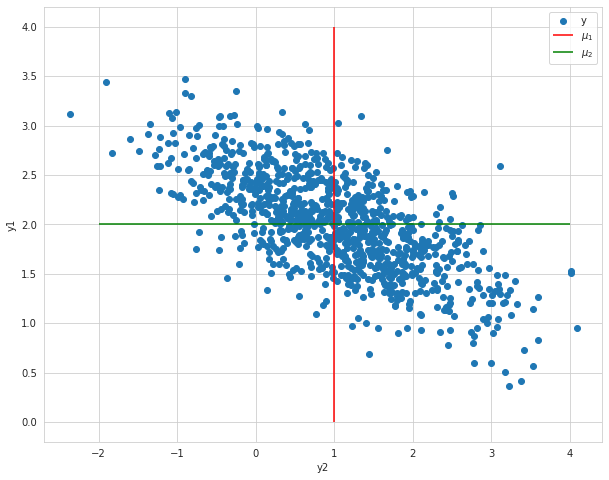

In [ ]:
N = 1000
y, Sigma = sample_data(N=N)

fig, ax = plt.subplots(figsize=(10,3))
ax.scatter(y[:,0], y[:,1], label = 'y')

ax.vlines(1, 0, 4, color = 'red', label = '$\mu_1$')
ax.hlines(2, -2, 4, color = 'green', label = '$\mu_2$')

ax.set_ylabel("y1")
ax.set_xlabel("y2")
ax.legend(loc="best")

fig.set_size_inches(10, 8)
plt.savefig('simulated_data_multi.pdf')  

In [ ]:
# Run MCMC, ADVI and RAABBVI and plot results
N = 1000
y, Sigma = sample_data(N=N)

import warnings
print('Inference using MCMC:')
posterior_samples = run_mcmc(model, 1000, 1000, 1, Sigma, y, True)
print('---------------------\n')
print('Inference using ADVI:')
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoMultivariateNormal", 500, 
                                            Sigma, y, tol = 0.01, 
                                            stopping = 'ELBO')
print('---------------------\n')
print('Inference using RAABBVI:')
results, approx = raabbvi(2, log_density=log_density, num_mc_samples=1)

Inference using MCMC:


sample: 100%|██████████| 2000/2000 [00:06<00:00, 331.62it/s, 3 steps of size 5.16e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      1.45      0.10      1.45      1.29      1.60    246.09      1.00
     mu[1]      1.99      0.08      1.98      1.85      2.11    197.19      1.00

Number of divergences: 0
---------------------

Inference using ADVI:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 13 iterations with default tol of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 4,582.1 | R hat converged|:  10%|█         | 1010/10000 [00:05<00:46, 193.85it/s]


Convergence reached at iteration 1010


average loss = 4,523.8 | R hat converged|:  16%|█▌        | 1406/8989 [00:06<00:36, 206.72it/s]


Convergence reached at iteration 1406


average loss = 4,523.2 | R hat converged|:  20%|█▉        | 1513/7582 [00:07<00:31, 191.11it/s]


Convergence reached at iteration 1513


average loss = 4,522.9 | R hat converged|:  68%|██████▊   | 4137/6068 [00:20<00:09, 204.83it/s]


Convergence reached at iteration 4137


Termination rule reached at iteration 8066
Inefficiency Index: 1.1635984449660832


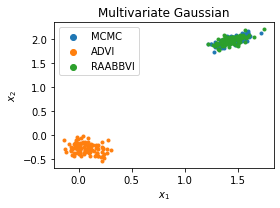

In [ ]:
idx = random.sample(range(1000), 100)
fig, ax = plt.subplots(figsize=(4,3))

ax.scatter(posterior_samples['mu'][idx, 0],
            posterior_samples['mu'][idx, 1],
            marker=".",
            label = 'MCMC')

samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (100,))

ax.scatter(samples_vi['mu'][:, 0],
            samples_vi['mu'][:, 1],
            marker=".",
            label = 'ADVI')

samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                    n_samples = 100)
ax.scatter(samples_raabbvi[:, 0],
            samples_raabbvi[:, 1],
            marker=".",
            label = 'RAABBVI')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend(loc = 'best', fontsize=10, markerscale=2)
plt.title("Multivariate Gaussian")
plt.tight_layout()
plt.savefig('experiment1_multi.pdf')  

# Section 3: Simulation studies 

## Section 3.1: How well does the stopping criterion, that was proposed in the original ADVI paper work?

In [ ]:
# Run simulation expertiment: 
# Research question: How does standard ADVI compare against RAABBVI?
# This simulation compares the MAD for mean and std for linear regression  
# Note: For std the MCMC estimate is used as the ground truth
resultMu = {('beta', 'advi'): [],
          ('sigma', 'advi'): [],
          ('beta', 'raabbvi'): [],
          ('sigma', 'raabbvi'): []}

resDfMu = pd.DataFrame(resultMu)

resultStd = {('beta', 'advi'): [],
              ('sigma', 'advi'): [],
              ('beta', 'raabbvi'): [],
              ('sigma', 'raabbvi'): []}

resDfStd = pd.DataFrame(resultStd)


resultW = {('beta', 'advi'): [],
              ('sigma', 'advi'): [],
              ('beta', 'raabbvi'): [],
              ('sigma', 'raabbvi'): []}

resDfW = pd.DataFrame(resultW)

resultKS = {('beta', 'advi'): [],
              ('sigma', 'advi'): [],
              ('beta', 'raabbvi'): [],
              ('sigma', 'raabbvi'): []}

resDfKS = pd.DataFrame(resultKS)


for i in range(10):
  print('\nIteration: {} of 10'.format(i+1))
  print('-------------------------')
  N = 20
  y, sigma, theta, mu, tau = sample_data(N=N)

  with HiddenPrints():
    posterior_samples = run_mcmc(model, 10000, 10000, 1, sigma, y)
    vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoDiagonalNormal", 2000, 
                                            sigma, y, tol = 0.01, 
                                            stopping = 'ELBO')
    results, _ = raabbvi(N+2, log_density=log_density, num_mc_samples=1)
  resMu_i, resStd_i, resW_i, resKS_i = getPerformance(N+2)
  resDfMu = resDfMu.append(resMu_i)
  resDfStd = resDfStd.append(resStd_i)
  resDfW = resDfW.append(resW_i)
  resDfKS = resDfKS.append(resKS_i)

  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 1 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:31<00:00, 642.36it/s, 15 steps of size 3.25e-01. acc. prob=0.91]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 52.892 | R hat converged|:  23%|██▎       | 2292/10000 [00:06<00:20, 378.98it/s]
average loss = 51.577 | R hat not converged|:  23%|██▎       | 1800/7707 [00:04<00:15, 383.64it/s]
average loss = 51.126 | R hat converged|:  92%|█████████▏| 5428/5906 [00:14<00:01, 372.58it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 2 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:29<00:00, 670.87it/s, 7 steps of size 3.89e-01. acc. prob=0.92] 


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 56.804 | R hat converged|:  23%|██▎       | 2288/10000 [00:06<00:20, 379.42it/s]
average loss = 55.497 | R hat converged|:  31%|███       | 2406/7711 [00:06<00:13, 382.75it/s]
average loss = 55.052 | R hat converged|: 100%|██████████| 5304/5304 [00:14<00:00, 360.32it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 3 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:29<00:00, 685.57it/s, 7 steps of size 3.74e-01. acc. prob=0.89]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 52.021 | R hat converged|:  18%|█▊        | 1802/10000 [00:04<00:21, 381.76it/s]
average loss = 50.838 | R hat converged|:  38%|███▊      | 3132/8197 [00:08<00:13, 374.04it/s]
average loss = 50.349 | R hat converged|:  89%|████████▉ | 4507/5064 [00:11<00:01, 376.62it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 4 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:28<00:00, 694.26it/s, 15 steps of size 2.83e-01. acc. prob=0.92]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 58.271 | R hat not converged|:  16%|█▌        | 1600/10000 [00:04<00:21, 391.81it/s]
average loss = 49.62 | R hat converged|:  34%|███▎      | 2817/8399 [00:07<00:14, 375.09it/s]
average loss = 48.842 | R hat converged|:  94%|█████████▍| 5268/5581 [00:14<00:00, 374.58it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 5 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:28<00:00, 696.13it/s, 15 steps of size 3.81e-01. acc. prob=0.91]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 54.371 | R hat converged|:  19%|█▉        | 1915/10000 [00:04<00:20, 385.19it/s]
average loss = 53.071 | R hat converged|:  39%|███▊      | 3122/8084 [00:08<00:13, 375.10it/s]
average loss = 52.479 | R hat converged|:  83%|████████▎ | 4100/4961 [00:10<00:02, 379.74it/s]
average loss = 52.385 | R hat not converged|: 100%|██████████| 860/860 [00:02<00:00, 397.69it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 6 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:28<00:00, 703.21it/s, 7 steps of size 4.43e-01. acc. prob=0.87]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 54.909 | R hat converged|:  20%|██        | 2040/10000 [00:05<00:20, 382.10it/s]
average loss = 53.81 | R hat converged|:  30%|███       | 2393/7959 [00:06<00:14, 380.13it/s]
average loss = 53.345 | R hat converged|: 100%|█████████▉| 5560/5565 [00:14<00:00, 372.37it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 7 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:29<00:00, 682.65it/s, 63 steps of size 8.74e-02. acc. prob=0.91]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 49.649 | R hat converged|:  19%|█▉        | 1911/10000 [00:04<00:20, 386.83it/s]
average loss = 48.493 | R hat converged|:  36%|███▌      | 2880/8088 [00:07<00:13, 382.35it/s]
average loss = 47.962 | R hat converged|:  91%|█████████ | 4738/5207 [00:12<00:01, 382.20it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 8 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:28<00:00, 693.66it/s, 7 steps of size 2.41e-01. acc. prob=0.93] 


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 49.683 | R hat converged|:  17%|█▋        | 1698/10000 [00:04<00:21, 392.71it/s]
average loss = 48.238 | R hat converged|:  33%|███▎      | 2780/8301 [00:07<00:14, 381.49it/s]
average loss = 47.702 | R hat converged|:  64%|██████▍   | 3538/5520 [00:09<00:05, 372.70it/s]
average loss = 47.411 | R hat not converged|: 100%|██████████| 1981/1981 [00:05<00:00, 385.20it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 9 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:29<00:00, 670.23it/s, 15 steps of size 2.83e-01. acc. prob=0.89]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 50.377 | R hat converged|:  17%|█▋        | 1697/10000 [00:04<00:21, 383.55it/s]
average loss = 49.027 | R hat not converged|:  26%|██▋       | 2200/8302 [00:05<00:15, 381.57it/s]
average loss = 48.562 | R hat converged|:  69%|██████▉   | 4211/6101 [00:11<00:05, 369.65it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 10 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:36<00:00, 550.92it/s, 15 steps of size 3.19e-01. acc. prob=0.92]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 49.719 | R hat converged|:  18%|█▊        | 1795/10000 [00:04<00:21, 382.24it/s]
average loss = 48.253 | R hat converged|:  29%|██▉       | 2393/8204 [00:06<00:15, 375.80it/s]
average loss = 47.868 | R hat converged|:  66%|██████▋   | 3850/5810 [00:10<00:05, 373.74it/s]


In [ ]:
#Output for \mu-MAD
df = resDfMu.reindex(columns=['mu', 'logtau'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(2).to_latex('sim1_mu_MAD.txt', index = False)

#Output for \sigma-MAD
df = resDfStd.reindex(columns=['mu', 'logtau'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(2).to_latex('sim1_sigma_MAD.txt', index = False)

#Output for Wasserstein
df = resDfW.reindex(columns=['mu', 'logtau'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(2).to_latex('sim1_W.txt', index = False)

#Output for KS
df = resDfKS.reindex(columns=['mu', 'logtau'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(5).to_latex('sim1_KS.txt', index = False)

## Section 3.2: Is RAABBVI always better than ADVI or does it only depend on the stopping criteria?

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
result = dict()
times = dict()
simTotal = 5
maxLog2T = 7

timesteps = [2**i for i in range(maxLog2T)]

for nsim in range(simTotal):
  print(nsim)

  #Is RAABBVI always better than ADVI? Or does it just depand on the stopping criteria?
  N = 20
  y, Sigma = sample_data(N=N)
  k=0

  # Get MCMC perfomance
  posterior_samples = run_mcmc(model, 5000, 5000, 1, Sigma, y)
  samples_mcmc = posterior_samples['mu'].to_py()

  # Get RAABVI performance
  t0_raabbvi = time.time()
  results, _ = raabbvi(2, log_density=log_density, num_mc_samples=1)
  t_raabbvi = time.time()-t0_raabbvi

  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                      n_samples = 2000)

  # Get ADVI performance for different number of iterations
  for k in timesteps:
    vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoDiagonalNormal", 10000, 
                                                  Sigma, y, stopping = 'time', tol = k)
    
    samplesVI = vi_guide.sample_posterior(PRNGKey(1), 
                                                vi_params, 
                                                (2000,))['mu'].to_py()   

    result[(k, nsim, 'ADVI', 'MAD', 'mu1')], result[(k, nsim, 'ADVI', 'MAD', 'mu2')] = \
      MADstats(samplesVI, samples_mcmc, N+2)

    result[(k, nsim, 'ADVI', 'varErr', 'mu1')], result[(k, nsim, 'ADVI', 'varErr', 'mu2')] = \
      varianceStats(samplesVI, samples_mcmc, N+2)

    result[(k, nsim, 'RAABBVI', 'MAD', 'mu1')], result[(k, nsim, 'RAABBVI', 'MAD', 'mu2')] = \
      MADstats(samples_raabbvi, samples_mcmc, N+2)

    result[(k, nsim, 'RAABBVI', 'varErr', 'mu1')], result[(k, nsim, 'RAABBVI', 'varErr', 'mu2')] = \
      varianceStats(samples_raabbvi, samples_mcmc, N+2)      

    result[(k, nsim, 'RAABBVI', 'time', '')] = t_raabbvi

    result[(k, nsim, 'ADVI', 'time', '')] = k

  #save results
  file_to_write = open("gdrive/My Drive/experiment1_results_multi.pickle", "wb")
  pickle.dump(result, file_to_write)


0


sample: 100%|██████████| 10000/10000 [00:12<00:00, 831.38it/s, 7 steps of size 5.90e-01. acc. prob=0.92]


Using cached StanModel for weighted_lin_regression


average loss = 71.562 | R hat converged|:   8%|▊         | 787/10000 [00:03<00:44, 204.90it/s]


Convergence reached at iteration 787


average loss = 45.623 | R hat converged|:   7%|▋         | 612/9212 [00:02<00:41, 205.21it/s]

Convergence reached at iteration 612



average loss = 45.294 | R hat converged|:  25%|██▍       | 2108/8599 [00:10<00:32, 199.67it/s]


Convergence reached at iteration 2108


Termination rule reached at iteration 3507
Inefficiency Index: 2.774882909881003


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 12 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 24 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 47 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 94 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 190 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 383 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 750 iterations with time tol of 64.
1


sample: 100%|██████████| 10000/10000 [00:11<00:00, 862.05it/s, 7 steps of size 5.37e-01. acc. prob=0.93]


Using cached StanModel for weighted_lin_regression


average loss = 68.962 | R hat converged|:   8%|▊         | 787/10000 [00:03<00:45, 203.28it/s]


Convergence reached at iteration 787


average loss = 43.828 | R hat converged|:   7%|▋         | 612/9212 [00:03<00:43, 198.17it/s]

Convergence reached at iteration 612



average loss = 43.499 | R hat converged|:  24%|██▍       | 2093/8599 [00:10<00:33, 196.64it/s]


Convergence reached at iteration 2093


Termination rule reached at iteration 3492
Inefficiency Index: 2.5744452204239585


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 12 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 24 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 47 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 94 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 188 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 380 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 746 iterations with time tol of 64.
2


sample: 100%|██████████| 10000/10000 [00:11<00:00, 837.63it/s, 7 steps of size 5.23e-01. acc. prob=0.94]


Using cached StanModel for weighted_lin_regression


average loss = 70.343 | R hat converged|:   8%|▊         | 787/10000 [00:03<00:45, 201.80it/s]


Convergence reached at iteration 787


average loss = 45.148 | R hat converged|:   7%|▋         | 613/9212 [00:03<00:42, 201.84it/s]


Convergence reached at iteration 613


average loss = 44.82 | R hat converged|:  25%|██▍       | 2108/8598 [00:10<00:32, 201.74it/s]


Convergence reached at iteration 2108


Termination rule reached at iteration 3508
Inefficiency Index: 2.6180802005502932


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 12 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 24 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 48 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 95 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 189 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 374 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 760 iterations with time tol of 64.
3


sample: 100%|██████████| 10000/10000 [00:11<00:00, 869.79it/s, 7 steps of size 6.25e-01. acc. prob=0.90]


Using cached StanModel for weighted_lin_regression


average loss = 70.35 | R hat converged|:   8%|▊         | 771/10000 [00:03<00:45, 203.92it/s]


Convergence reached at iteration 771


average loss = 43.066 | R hat converged|:   7%|▋         | 638/9228 [00:03<00:42, 199.91it/s]

Convergence reached at iteration 638



average loss = 42.74 | R hat converged|:  25%|██▍       | 2132/8589 [00:10<00:32, 200.37it/s]

Convergence reached at iteration 2132


Termination rule reached at iteration 3541
Inefficiency Index: 2.690553326033979


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 12 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 24 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 48 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 94 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 190 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 361 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 758 iterations with time tol of 64.
4


sample: 100%|██████████| 10000/10000 [00:11<00:00, 878.98it/s, 7 steps of size 5.27e-01. acc. prob=0.93]


Using cached StanModel for weighted_lin_regression


average loss = 66.836 | R hat converged|:   8%|▊         | 788/10000 [00:03<00:44, 206.52it/s]


Convergence reached at iteration 788


average loss = 39.283 | R hat converged|:   7%|▋         | 613/9211 [00:03<00:42, 204.07it/s]

Convergence reached at iteration 613



average loss = 38.955 | R hat converged|:  25%|██▍       | 2134/8597 [00:10<00:32, 197.36it/s]


Convergence reached at iteration 2134


Termination rule reached at iteration 3535
Inefficiency Index: 2.821730705285997


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 6 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 24 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 49 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 94 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 188 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 376 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 752 iterations with time tol of 64.


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


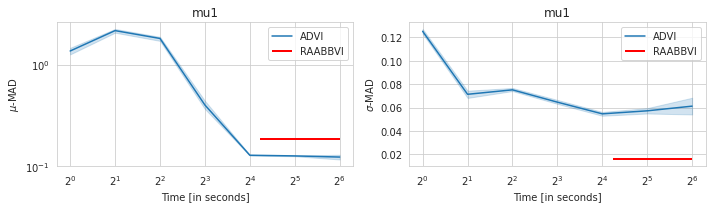

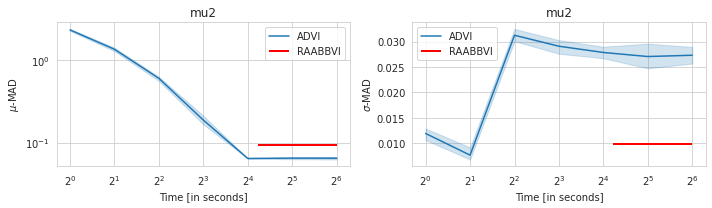

In [ ]:
file_res = open("gdrive/My Drive/experiment1_results_multi.pickle",'rb')
result = pickle.load(file_res)

df = pd.DataFrame(result).stack(level = [0,1])
df.index = df.index.droplevel(level = 0)
df.reset_index(inplace = True)

def plotSimulation1(colname, kpi, df, ax, time = True):
  dfMAD = df.loc[:, (slice(None), kpi, colname)]
  dfMAD.columns = [col[0] for col in dfMAD.columns]
  dfMAD = dfMAD.reset_index()
  dfMAD.drop(columns = ['index'], inplace = True)

  if time: 
    dfMAD['t_advi'] = df.loc[:, ('ADVI', 'time')].values
    dfMAD['t_raabbvi'] = df.loc[:, ('RAABBVI', 'time')].values

    tmin = dfMAD['t_advi'].min()
    tmax = dfMAD['t_advi'].max()

    sns.set_style('whitegrid')
    sns.lineplot(data = dfMAD, x = 't_advi', y = 'ADVI', ax = ax,
                 label = 'ADVI')

    t_RAABBVI = dfMAD['t_raabbvi'].mean()
    val_RAABBVI = dfMAD['RAABBVI'].mean()

    ax.hlines(y=val_RAABBVI, xmin=t_RAABBVI, xmax=dfMAD['t_advi'].max(), 
              linewidth=2, color='r', label = 'RAABBVI')

    ax.set_xscale('log', basex=2)
    ax.set_title(colname)
    ax.set_xlabel('Time [in seconds]')
    ax.legend(loc="best")
    if kpi == 'MAD':   
      ax.set_ylabel('$\mu$-MAD')
      ax.set_yscale('log')
    if kpi == 'varErr':
      ax.set_ylabel('$\sigma$-MAD')

  else:
    dfMAD['k'] = 2**df['level_0']

    dfMAD_melted = dfMAD.melt('k', var_name='Method', value_name=kpi)
    sns.set_style('whitegrid')

    sns.lineplot(data = dfMAD_melted, x = 'k', y = kpi, hue = 'Method', 
                      style = 'Method', ax = ax)
    ax.set_xscale('log', basex=2)
    ax.set_title(colname)
    ax.set_xlabel('Number of iterations')
    if kpi == 'MAD':   
      ax.set_ylabel('$\mu$-MAD')
      ax.set_yscale('log')
    if kpi == 'varErr':
      ax.set_ylabel('$\sigma$-MAD')

sns.set_style('whitegrid')
fig, ax = plt.subplots(ncols = 2, figsize=(10,3))
plotSimulation1('mu1', 'MAD', df, ax[0])
plotSimulation1('mu1', 'varErr', df, ax[1])
plt.tight_layout()
plt.savefig('gdrive/My Drive/experiment2_multi_mu1.pdf')  

sns.set_style('whitegrid')
fig, ax = plt.subplots(ncols = 2, figsize=(10,3))
plotSimulation1('mu2', 'MAD', df, ax[0])
plotSimulation1('mu2', 'varErr', df, ax[1])
plt.tight_layout()
plt.savefig('gdrive/My Drive/experiment2_multi_mu2.pdf')  


## Section 3.3: Are there alternative stopping criteria for ADVI that match the performance of RAABBVI?

In [ ]:
# Run simulation with different stopping criteria: 
# 1: Relative improvement in ELBO 
# 2: PSIS k < 0.7 
# 3: Relative improvement in W2 bound 
# 4: RAABBVI 
# 5: MCMC
# Output: 

result = {}
for k in range(5):
  N = 100
  D = 2

  y, Sigma = sample_data(N=N)
#  ground_truth = np.r_[beta, sigma]

  import warnings
  print('Inference using MCMC:')
  posterior_samples = run_mcmc(model, 1000, 1000, 1, Sigma, y, True)
  samples_mcmc = posterior_samples['mu'].to_py()

  print('---------------------\n')
  for rule in ['ELBO', 'PSIS', 'rhat', 'wasserstein']: #, 'PSIS',
    print('Inference using ADVI with {}:'.format(rule))
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoMultivariateNormal", 500, 
                                                Sigma, y, tol = 0.01, 
                                                stopping = rule)
      samplesVI = vi_guide.sample_posterior(PRNGKey(1), 
                                            vi_params, 
                                            (2000,))['mu'].to_py()

      result[(k, 'MAD', 'mu1', rule)], result[(k, 'MAD', 'mu2', rule)] = \
        MADstats(samplesVI, samples_mcmc, D)

      result[(k, 'varErr', 'mu1', rule)], result[(k, 'varErr', 'mu2', rule)] = \
        varianceStats(samplesVI, samples_mcmc, D)

  print('---------------------\n')
  print('Inference using RAABBVI:')
  results, approx = raabbvi(D, log_density=log_density, num_mc_samples=1)
  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                      n_samples = 2000)
  result[(k, 'MAD', 'mu1', 'RAABBVI')], result[(k, 'MAD', 'mu2', 'RAABBVI')] = \
    MADstats(samples_raabbvi, samples_mcmc, D)

  result[(k, 'varErr', 'mu1', 'RAABBVI')], result[(k, 'varErr', 'mu2', 'RAABBVI')] = \
    varianceStats(samples_raabbvi, samples_mcmc, D)

Inference using MCMC:


sample: 100%|██████████| 2000/2000 [00:04<00:00, 428.39it/s, 3 steps of size 5.47e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      0.99      0.29      0.99      0.56      1.49    406.31      1.00
     mu[1]      1.93      0.25      1.93      1.47      2.29    382.68      1.00

Number of divergences: 0
---------------------

Inference using ADVI with ELBO:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 13 iterations with default tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/500 [00:00<?, ?it/s]

Inference using ADVI with rhat:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 188 iterations with rhat of 0.01.
Inference using ADVI with wasserstein:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 2 iterations with W2 tol of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 451.05 | R hat converged|:   8%|▊         | 787/10000 [00:04<00:48, 189.03it/s]


Convergence reached at iteration 787


average loss = 441.53 | R hat converged|:   9%|▉         | 817/9212 [00:04<00:44, 186.81it/s]

Convergence reached at iteration 817



average loss = 441.37 | R hat converged|:  26%|██▌       | 2171/8394 [00:11<00:33, 186.75it/s]


Convergence reached at iteration 2171


Termination rule reached at iteration 3775
Inefficiency Index: 2.15740635116906
Inference using MCMC:


sample: 100%|██████████| 2000/2000 [00:04<00:00, 429.39it/s, 7 steps of size 5.74e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      1.00      0.29      1.00      0.48      1.40    234.26      1.00
     mu[1]      1.65      0.25      1.65      1.27      2.07    230.10      1.00

Number of divergences: 0
---------------------

Inference using ADVI with ELBO:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 13 iterations with default tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/500 [00:00<?, ?it/s]

Inference using ADVI with rhat:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 181 iterations with rhat of 0.01.
Inference using ADVI with wasserstein:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 2 iterations with W2 tol of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 465.32 | R hat converged|:   8%|▊         | 791/10000 [00:04<00:49, 185.04it/s]


Convergence reached at iteration 791


average loss = 456.47 | R hat converged|:   9%|▉         | 810/9208 [00:04<00:45, 184.80it/s]


Convergence reached at iteration 810


average loss = 456.32 | R hat converged|:  25%|██▍       | 2097/8397 [00:11<00:34, 184.82it/s]


Convergence reached at iteration 2097


Termination rule reached at iteration 3698
Inefficiency Index: 1.983127628299766
Inference using MCMC:


sample: 100%|██████████| 2000/2000 [00:04<00:00, 418.52it/s, 7 steps of size 5.48e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      1.09      0.28      1.09      0.58      1.51    260.46      1.00
     mu[1]      1.31      0.24      1.33      0.90      1.67    257.53      1.00

Number of divergences: 0
---------------------

Inference using ADVI with ELBO:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 13 iterations with default tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/500 [00:00<?, ?it/s]

Inference using ADVI with rhat:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 170 iterations with rhat of 0.01.
Inference using ADVI with wasserstein:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 2 iterations with W2 tol of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 459.12 | R hat converged|:   8%|▊         | 787/10000 [00:04<00:49, 187.07it/s]


Convergence reached at iteration 787


average loss = 450.99 | R hat converged|:   9%|▉         | 823/9212 [00:04<00:43, 191.12it/s]


Convergence reached at iteration 823


average loss = 450.83 | R hat converged|:  25%|██▌       | 2122/8388 [00:11<00:33, 185.97it/s]


Convergence reached at iteration 2122


Termination rule reached at iteration 3732
Inefficiency Index: 2.135338603211662
Inference using MCMC:


sample: 100%|██████████| 2000/2000 [00:04<00:00, 418.77it/s, 7 steps of size 5.37e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      1.17      0.27      1.17      0.69      1.56    319.77      1.00
     mu[1]      1.57      0.23      1.60      1.15      1.90    247.20      1.00

Number of divergences: 0
---------------------

Inference using ADVI with ELBO:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 13 iterations with default tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/500 [00:00<?, ?it/s]

Inference using ADVI with rhat:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 174 iterations with rhat of 0.01.
Inference using ADVI with wasserstein:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 2 iterations with W2 tol of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 460.02 | R hat converged|:   8%|▊         | 787/10000 [00:04<00:47, 192.66it/s]


Convergence reached at iteration 787


average loss = 451.4 | R hat converged|:   9%|▉         | 810/9212 [00:04<00:46, 182.59it/s]


Convergence reached at iteration 810


average loss = 451.24 | R hat converged|:  26%|██▌       | 2149/8401 [00:11<00:34, 180.14it/s]

Convergence reached at iteration 2149


Termination rule reached at iteration 3746
Inefficiency Index: 1.9888951365394998
Inference using MCMC:


sample: 100%|██████████| 2000/2000 [00:04<00:00, 415.88it/s, 7 steps of size 5.49e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     mu[0]      1.14      0.28      1.14      0.65      1.56    262.42      1.00
     mu[1]      1.62      0.24      1.63      1.24      2.01    223.63      1.00

Number of divergences: 0
---------------------

Inference using ADVI with ELBO:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 13 iterations with default tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/500 [00:00<?, ?it/s]

Inference using ADVI with rhat:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 177 iterations with rhat of 0.01.
Inference using ADVI with wasserstein:


  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 2 iterations with W2 tol of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 475.25 | R hat converged|:   8%|▊         | 787/10000 [00:04<00:49, 186.05it/s]


Convergence reached at iteration 787


average loss = 466.53 | R hat converged|:   9%|▉         | 812/9212 [00:04<00:44, 186.73it/s]


Convergence reached at iteration 812


average loss = 466.36 | R hat converged|:  25%|██▍       | 2099/8399 [00:12<00:37, 169.84it/s]


Convergence reached at iteration 2099


Termination rule reached at iteration 3698
Inefficiency Index: 1.9678724149317546


In [ ]:
df = pd.DataFrame(result).stack(level = 0)
df2 = pd.DataFrame(df.loc[:, ('MAD', slice(None), slice(None))].mean()).reset_index()
df2.columns = ['col'+str(i) for i in range(len(df2.columns))]
df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2).to_latex('experiment3_mu.txt')
print(df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2))

print("-----")
df = pd.DataFrame(result).stack(level = 0)
df2 = pd.DataFrame(df.loc[:, ('varErr', slice(None), slice(None))].mean()).reset_index()
df2.columns = ['col'+str(i) for i in range(len(df2.columns))]
df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2).to_latex('experiment3_sigma.txt')
print(df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2))

col2  ELBO  PSIS  RAABBVI  rhat  wasserstein
col1                                        
mu1    1.0  0.23     0.24  0.22         0.11
mu2    1.9  0.20     0.20  0.19         2.95
-----
col2  ELBO  PSIS  RAABBVI  rhat  wasserstein
col1                                        
mu1   0.05  0.01     0.02  0.01         0.16
mu2   0.06  0.01     0.01  0.01         0.12
